In [1]:
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pickle as pk
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy import stats
import numpy as np, scipy.stats as st
from sklearn.decomposition import PCA
import copy
import warnings
warnings.filterwarnings('ignore')

## Do this same analysis (Method 2) on the UMass Private Well Dataset

In [2]:
receptor_df = gpd.read_file('../../../data/modeling_data/private_well_holdout.geojson')
receptor_df['GEOID10'] = receptor_df['GEOID10'].astype(str).str.zfill(12)
receptor_df['centroid'] = receptor_df['geometry'].centroid
receptor_gdf = gpd.GeoDataFrame(
    receptor_df,
    geometry=gpd.points_from_xy(receptor_df.centroid.x, receptor_df.centroid.y),
    crs={"init":"EPSG:4326"})

In [3]:
regions = gpd.read_file('../../../data/regdep.geojson', drive = 'GeoJSON')
regions = regions.to_crs('EPSG:4326')

In [4]:
receptor_df = gpd.sjoin(receptor_gdf, regions[['geometry', 'REGION']], op='within') 

In [5]:
receptor_df.groupby('REGION').size()

REGION
CEN      27
NE      190
SE      242
WEST    164
dtype: int64

In [6]:
receptor_df = receptor_df[receptor_df['REGION'] == 'WEST'].reset_index()

In [7]:
orig_df = receptor_df.copy()

In [8]:
# Wastewater also contains extra compounds that are not a part of the PFAS18 collection (PFDS, PFPeA, PFTeDA, PFPeS, PFNS, PFHpS)
# Remove these variables based on PFAS_18 compounds list

pfas18 = pd.read_csv('../../../data/Extracted lab report data/PFAS_compounds.csv')[['Acronym','PFAS18']]
pfas18 = pfas18[~(pfas18['PFAS18'].isna())]['Acronym']

In [9]:
pfas_vars = utils.get_pfas_vars(df = receptor_df,
                                pfas18 = pfas18)

Normalize from 0 to 1 for display purposes (e.g., EDA) only. The actual data will be z-score normalized
(standardized) before PCA and HC.

In [10]:
# receptor_df = receptor_df_final.copy()
receptor_df_eda = utils.normalize_over_partitions(df = receptor_df, 
                                              pfas_vars = pfas_vars,
                                              units_col = 'Matrix',
                                              scaler_fn = 'MinMax')

## Visualize Profile

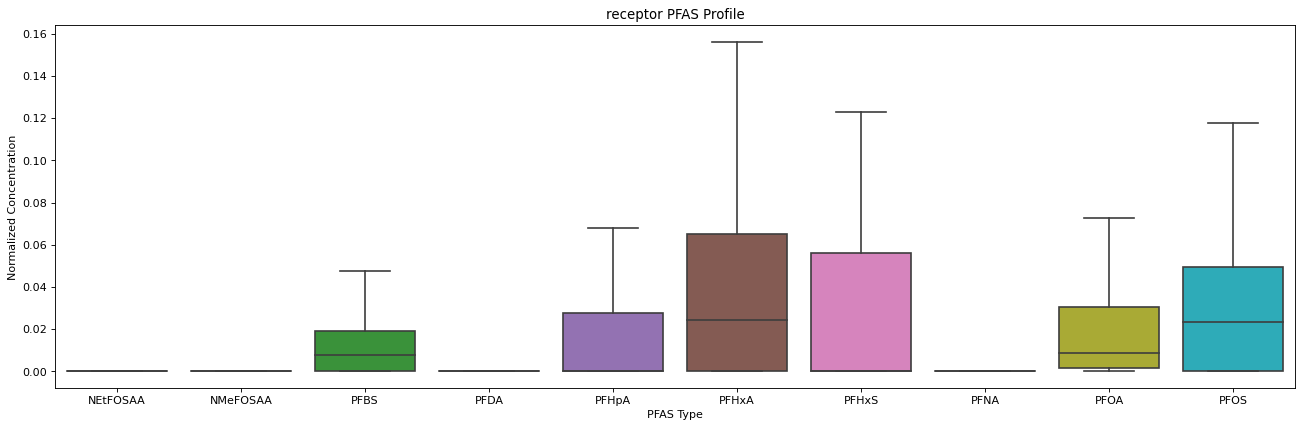

In [11]:
# Should this be in molecular weight order?? - Easier to compare across different sources/samples

plt.figure(figsize=(20, 6), dpi=80)
plt.title('receptor PFAS Profile')

# pd.melt(receptor_df_eda[pfas_vars])
sns.boxplot(x="variable", y="value", data=pd.melt(receptor_df_eda[pfas_vars]), showfliers = False)
plt.xlabel('PFAS Type')
plt.ylabel('Normalized Concentration')
plt.show()

### Transform using Profiles

In [12]:
num_pcs_dict = {'AFFF' : 3,
           'airport' : 2,
           'other' : 3,
           'residential' : 3}

other_PC_profiles_names = {'PC1' : 'Industrial Manufacturing Mix', 
                           'PC2' : 'Waste/Landfills', 
                           'PC3':'Other (Coatings/Inks and other)'}

Standardize receptor data

In [13]:
receptor_df_pca = copy.deepcopy(receptor_df)
receptor_df_pca = utils.normalize_over_partitions(df = receptor_df_pca, 
                                          pfas_vars = pfas_vars,
                                          units_col = 'Matrix',
                                          scaler_fn = 'Zscore')
input_df = receptor_df_pca[pfas_vars].copy()

AFFF

In [14]:
# Create AFFF transformation based on number of principal components
afff_df = pd.read_csv('../../../data/modeling_data/source_attribution/afff_source.csv')

afff_APCS_df = utils.APCS_pipeline(source_df = afff_df,
                                   receptor_df = receptor_df,
                                   receptor_df_pca = input_df,
                                   pfas_vars = pfas_vars,
                                   source_name = 'AFFF',
                                   units_col = 'Matrix',
                                   num_pcs = num_pcs_dict)

Airport

In [15]:
# Create airport transformation based on number of principal components
airport_df = pd.read_csv('../../../data/modeling_data/source_attribution/airport_source.csv')

airport_APCS_df = utils.APCS_pipeline(source_df = airport_df,
                                   receptor_df = receptor_df,
                                   receptor_df_pca = input_df,
                                   pfas_vars = pfas_vars,
                                   source_name = 'airport',
                                   units_col = 'Units',
                                   num_pcs = num_pcs_dict)

Other

In [16]:
# Create other transformation based on number of principal components
other_df = pd.read_csv('../../../data/modeling_data/source_attribution/other_source.csv')

other_APCS_df = utils.APCS_pipeline(source_df = other_df,
                                   receptor_df = receptor_df,
                                   receptor_df_pca = input_df,
                                   pfas_vars = pfas_vars,
                                   source_name = 'other',
                                   units_col = 'Units',
                                   num_pcs = num_pcs_dict)

Residential

In [17]:
# Create residential transformation based on number of principal components
residential_df = pd.read_csv('../../../data/modeling_data/source_attribution/residential_source.csv')

residential_APCS_df = utils.APCS_pipeline(source_df = residential_df,
                                   receptor_df = receptor_df,
                                   receptor_df_pca = input_df,
                                   pfas_vars = pfas_vars,
                                   source_name = 'residential',
                                   units_col = 'Units',
                                   num_pcs = num_pcs_dict)

Create modeling dataset

In [18]:
sources = num_pcs_dict.keys()
concat_df = pd.concat([afff_APCS_df, airport_APCS_df, residential_APCS_df, other_APCS_df], axis = 1)
predictor_list = concat_df.columns
concat_df[pfas_vars] = receptor_df[pfas_vars]

Due to models that do not fit well - remove NMeFOSAA

In [19]:
concat_df.drop(columns = 'NMeFOSAA', inplace = True)
pfas_vars.remove('NMeFOSAA')

### Attribution Modeling

Check for highly correlated variables

In [20]:
print('Top Absolute Correlations')
utils.get_top_abs_correlations(concat_df[predictor_list],
                        corr_cutoff = 0.85)

Top Absolute Correlations


,level_0,level_1,0
0,airport_0,other_0,0.990100
1,residential_0,other_0,0.945180
2,airport_0,residential_0,0.910415
3,airport_1,other_1,0.888893


Since airport_0 is most highly correlated with airport_0 -- if removed from model, then airport_0 will share contribution with residential_0. Since, airport_0 is not too highly correlated with AFFF_0 - no additional change beyond this is needed

In [21]:
# Manual entry
removed_vars = {'other_0' : ['airport_0', 'residential_0']}

In [22]:
for var, remove_list in removed_vars.items():
    concat_df.drop(columns = remove_list, inplace = True)
    
predictor_list = concat_df.columns

Fit model

In [23]:
# bootstrap 10 times to get confidence interval
n_iterations = 50
model2_info = utils.fit_model(concat_df, predictor_list, pfas_vars, n_iterations)

Calculate confidence intervals

In [24]:
source_names, means, yerror = utils.calc_contribution_confidence_intervals(concat_df, model2_info, pfas_vars, sources, n_iterations, removed_vars, num_pcs_dict, other_PC_profiles_names)

UnboundLocalError: local variable 'source_names' referenced before assignment

In [ ]:
x = source_names
y = means

plt.figure(figsize=(15, 10), dpi=80)
plt.title('WEST - Confidence Intervals for Source Attribution', fontsize = 20)

plt.xlabel('Source Type', fontsize = 14)
plt.ylabel('Attribution (%)', fontsize = 14)

plt.errorbar(range(len(x)),y,yerr = yerror, fmt = 'o', ecolor = 'black', capsize = 5, ms = 5)
plt.xticks(range(len(x)), x,fontsize = 12)

In [ ]:
# (Average variance explained by model, standard deviation)
utils.calculate_average_model_score(model2_info, n_iterations, sources, pfas_vars)

In [26]:
for pfas in pfas_vars[:]:

    rs = resample(concat_df, n_samples = concat_df.shape[0], random_state = 42).copy()
    X = rs[predictor_list]
    y = rs[pfas].copy()

    lm = PoissonRegressor().fit(X, y)
    lm.intercept_
    lm.coef_
    print(pfas, lm.score(X, y))
    mean_squared_error(y, lm.predict(X))

NEtFOSAA nan
PFBS -2.220446049250313e-16
PFDA 8.881784197001252e-16
PFHpA 0.0
PFHxA 0.0
PFHxS 1.1102230246251565e-16
PFNA -2.220446049250313e-16
PFOA 0.0
PFOS 0.0
